# Description

<p> This notebook describes how to generate training data to train a Diffusion Convolutional Recurrent Neural Network.
DCRNN expects the graph to be represented as an adjacency matrix, with the values representing closeness or connectedness between the nodes.
Additionally, since the nature of the data is spatio-temporal, we also expect a time series of values at every node. 
Below we see how to generate data to train DCRNN from the above mentioned sources. 
</p>

## What should the adjacency matrix represent? 

The adjacency matrix could be thought of as the kernel in Machine Learning, with each value corresponding to a distance metric. 

For eg., in the traffic data below, the values in the adjacency matrix represent actual distances between 2 road sensors.

In [17]:
import pickle

graph = pickle.load(open('DCRNN_PyTorch/data/sensor_graph/adj_mx_bay.pkl','rb'),encoding= 'latin1')

print("Shape of adjacency matrix")
print(graph[2].shape)

Shape of adjacency matrix
(325, 325)


Thus this particular graph consists of 325 sensors.

In [18]:
# Since traffic data is huge the input data format is an hdf file. 
# Other popular formats like .csv,.jsons should be a good place to start. 

import pandas as pd

hdf=pd.HDFStore('~/Downloads/pems-bay.h5')
df = hdf['speed']

In [19]:
df.shape

(52116, 325)

## Dataset Description

<p>
    
The Caltrans Freeway Performance Measurement System (PeMS) standard rollup provides a variety of measurements (number of vehicles, average speed, etc.) for both individual lanes and across all lanes in five-minute intervals aggregated from the raw 30-second intervals. 

For the purposes of this task we use 6 months worth of data scraped from the Caltrans website and focussed on the San Francisco Bay Area to predict traffic speeds upto 1 hour in the future effectively. The Bay Area road network has 325 traffic sensors as of the year 2017 and the traffic speeds at each of these sensors can be seen at 5 minute intervals. 

**Link from which data was acquired:** <br>
http://pems.dot.ca.gov/?dnode=Clearinghouse

</p>

In [20]:
df.head(2)

sensor_id,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4


Here we can see a time series for every node with 52116 values at 5 minute intervals.

## Data cleaning - handling missing values

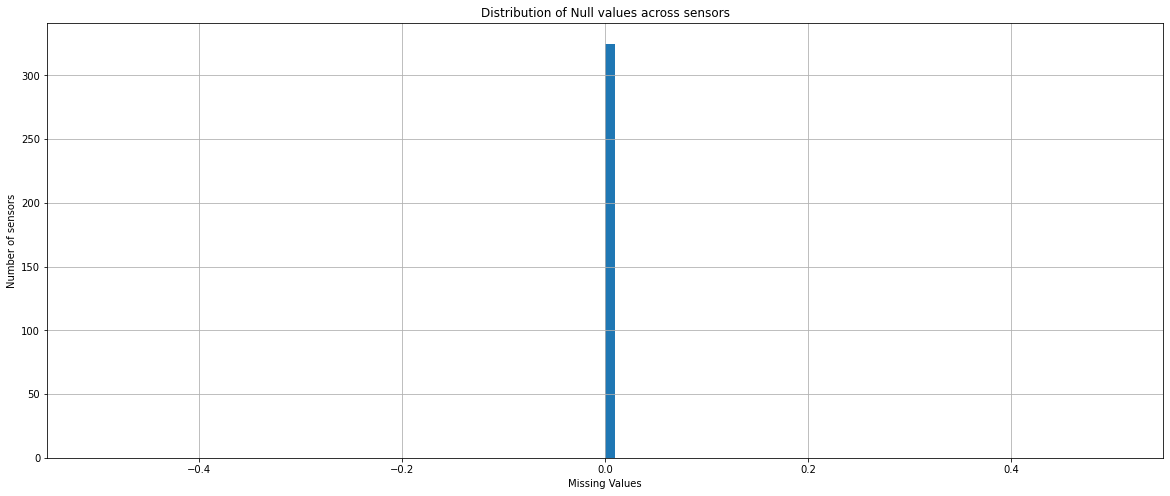

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,8))
plt.title('Distribution of Null values across sensors')
df[df.isnull().any(axis = 1)].isnull().sum(axis = 0).hist(bins = 100)
plt.xlabel('Missing Values')
plt.ylabel('Number of sensors')
plt.show()

This particular dataset does not have null values. However, it must be noted that null values **must** be imputed prior to training DCRNN. 

Popular time series null value imputation techniques can be found below 

https://otexts.com/fpp2/missing-outliers.html

# Data generation

<p> While DCRNN is a graph convolution, it still relys on a sequence to sequence architechture to learn temporal characteristics.
The underlying method takes the dataframe of sensors with speed values over time and breaks it down into sequence to sequnce steps, based on the horizon defined
</p>

DCRNN, the supervised training model expects an x and a y tensor of the following dimensions

Input/ Encoder sequence

    - Epoch size  (Number of training sequences)
    - Input Length 
    - Number of Nodes (The number of nodes in the graph , equivalent to the adjacency matrix)
    - Input dimension (Number of features per node, in this case speed, time of day, etc.)

Output/ Decoder sequence (Number of training sequences)

    - Epoch size  (Number of training sequences)
    - Output Length (Often equal to the horizon)
    - Number of Nodes (The number of nodes in the graph , equivalent to the adjacency matrix)
    - Output dimension (Number of output features per node, in this case speed)

In [22]:
import numpy as np
import os

def generate_graph_seq2seq_io_data(df, x_offsets, y_offsets, add_time_in_day=False, add_day_in_week=False):
    """
    This method generates data in the sequence to sequence format expected by DCRNN. 
    
    It also consists of additional functionality of adding temporal features like Time of day and Day of week, 
    which can be ignored if required. 
    
    :param df: DataFrame of nodes and time series.
    
    :param x_offsets: Offsets derived from the horizon.  
    :param y_offsets: 

    :param add_time_in_day: (OPTIONAL) add temporal feature time in the day.
    :param add_day_in_week: (OPTIONAL) add temporal feature day in the week. 

    
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    
    # Can be replaced with any features you like. 
    
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    
    return x, y

Since DCRNN is about spatial and also temporal forecasting, we must specify a sequence length or horizon which determines how far we want to predict in the future.

In [23]:
# Number corresponding to how far you want to predict in the future. 

horizon = 12

percent_train = 0.8
percent_test = 0.2

Since we want to predict one hour into the future, and our data constitutes of speeds at 5 minute intervals, we select our horizon to be 12

### 1. Create offsets for input and output

In [24]:
x_offsets = np.sort(

    np.concatenate((np.arange(-(horizon-1), 1, 1),))
)

# Predict until the horizon
y_offsets = np.sort(np.arange(1, (horizon + 1), 1))

In [25]:
x_offsets

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0])

In [26]:
y_offsets

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### 2. Generate sequences of data using defined offsets

In [27]:
# x: (num_samples, input_length, num_nodes, input_dim)
# y: (num_samples, output_length, num_nodes, output_dim)

x, y = generate_graph_seq2seq_io_data(
    df,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
)

print("x shape: ", x.shape, ", y shape: ", y.shape)

# Write the data into .npz file.

x shape:  (52093, 12, 325, 1) , y shape:  (52093, 12, 325, 1)


### 3. Split sequences train test and val

In [28]:
# Calculate number of samples 

num_samples = x.shape[0]

# For the rest: 7/8 is used for training, and 1/8 is used for validation.

num_test = round(num_samples * percent_test)
num_train = round(num_samples * (percent_train - 0.1))
num_val = num_samples - num_test - num_train

In [29]:
# Generate train test and validation data and write to the output directory for the model to fetch.

x_train, y_train = x[:num_train], y[:num_train]

x_val, y_val = (
    x[num_train: num_train + num_val],
    y[num_train: num_train + num_val],
)

x_test, y_test = x[-num_test:], y[-num_test:]

### 4. Write to an output directory

In [ ]:
out_dir = 'traffic' # Make sure this directory is made before
datasets = {}

for cat in ["train", "val", "test"]:
    _x, _y = locals()["x_" + cat], locals()["y_" + cat]

    print(cat, "x: ", _x.shape, "y:", _y.shape)

    np.savez_compressed(
        os.path.join(out_dir, "%s.npz" % cat),
        x=_x,
        y=_y,
        x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
        y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
    )
    datasets["x_" + cat] = _x
    datasets["y_" + cat] = _y

train x:  (36465, 12, 325, 1) y: (36465, 12, 325, 1)
val x:  (5209, 12, 325, 1) y: (5209, 12, 325, 1)
test x:  (10419, 12, 325, 1) y: (10419, 12, 325, 1)


# FINAL STEP - Train newly created data!